In [345]:
# Activate env
import os
os.system("source ~/tensorflow-env/bin/activate")

# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

# Helper libraries

import sys
import time
import datetime

import numpy as np
import pandas as pd
import sklearn
from   sklearn.model_selection import train_test_split

import IPython
import IPython.display
import seaborn as sns


TensorFlow version: 2.14.0
Keras version: 2.14.0


sh: 1: source: not found


In [346]:
import requests
from pathlib import Path

API_KEY = '1f84d670-164a-45bd-b8d5-abeca59cbf10'  # Replace with your ENTSO-E token
DOMAIN = '10Y1001A1001A46L'    # SE3
BASE_URL = 'https://web-api.tp.entsoe.eu/api'
SAVE_DIR = Path('entsoe_price_data')
SAVE_DIR.mkdir(exist_ok=True)

def fetch_monthly_prices(year, month):
    start = datetime.datetime(year, month, 1)
    if month == 12:
        end = datetime.datetime(year + 1, 1, 1)
    else:
        end = datetime.datetime(year, month + 1, 1)

    period_start = start.strftime('%Y%m%d%H%M')
    period_end = end.strftime('%Y%m%d%H%M')

    params = {
        'securityToken': API_KEY,
        'documentType': 'A44',  # Day-ahead prices
        'in_Domain': DOMAIN,
        'out_Domain': DOMAIN,
        'periodStart': period_start,
        'periodEnd': period_end
    }

    print(f"Fetching {period_start} to {period_end}...")
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        filename = SAVE_DIR / f'prices_{year}_{month:02}.xml'
        filename.write_bytes(response.content)
        print(f"Saved to {filename}")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
    time.sleep(1)  # Be nice to ENTSO-E servers


# Skip fetching data multiple times
"""
# Loop over all months from 2010 to now
start_year = 2010
end = datetime.datetime.now()
for year in range(start_year, end.year + 1):
    for month in range(1, 13):
        if year == end.year and month > end.month:
            break
        fetch_monthly_prices(year, month)
"""

'\n# Loop over all months from 2010 to now\nstart_year = 2010\nend = datetime.datetime.now()\nfor year in range(start_year, end.year + 1):\n    for month in range(1, 13):\n        if year == end.year and month > end.month:\n            break\n        fetch_monthly_prices(year, month)\n'

In [347]:
import xml.etree.ElementTree as ET
from datetime import timedelta

tree = ET.parse('entsoe_price_data/prices_2015_06.xml')
root = tree.getroot()
print(root.tag)

{urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:3}Publication_MarketDocument


In [348]:
from zoneinfo import ZoneInfo


DATA_DIR = Path('entsoe_price_data')

def parse_price_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    ns = {'ns': 'urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:3'}

    # Find all time series
    prices = []
    for timeseries in root.findall('ns:TimeSeries', ns):
        period = timeseries.find('ns:Period', ns)
        if period is None:
            continue

        resolution_tag = period.find('ns:resolution', ns)
        if resolution_tag is None:
            continue

        resolution = resolution_tag.text
        if resolution != 'PT60M':
            continue
        
        period = timeseries.find('ns:Period', ns)
        start = datetime.datetime.strptime(period.find('ns:timeInterval/ns:start', ns).text, '%Y-%m-%dT%H:%MZ')
        points = period.findall('ns:Point', ns)

        for point in points:
            position = int(point.find('ns:position', ns).text)
            price = float(point.find('ns:price.amount', ns).text)  # ENTSO-E gives prices in € / 10
            timestamp = start + timedelta(hours=position - 1)
            prices.append((timestamp, price))
    
    return prices

# Collect data from all XMLs
all_data = []
for xml_file in sorted(DATA_DIR.glob('*.xml')):
    all_data.extend(parse_price_xml(xml_file))

# Create DataFrame
data_EL = pd.DataFrame(all_data, columns=['datetime', 'price_eur_mwh'])
data_EL.sort_values('datetime', inplace=True)
data_EL.reset_index(drop=True, inplace=True)



data_EL['datetime'] = data_EL['datetime'].dt.tz_localize('UTC').dt.tz_convert(ZoneInfo('Europe/Stockholm'))


# Optional: show the first few rows
display(data_EL)


,datetime,price_eur_mwh
0,2014-12-12 00:00:00+01:00,29.52
1,2014-12-12 01:00:00+01:00,29.23
2,2014-12-12 02:00:00+01:00,29.14
3,2014-12-12 03:00:00+01:00,29.11
4,2014-12-12 04:00:00+01:00,29.49
...,...,...
94172,2025-06-03 19:00:00+02:00,39.61
94173,2025-06-03 20:00:00+02:00,43.60
94174,2025-06-03 21:00:00+02:00,48.29
94175,2025-06-03 22:00:00+02:00,43.33


In [349]:
import pytz
data_EL['Datetime'] = pd.to_datetime(data_EL['datetime'], utc=True, format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
data_EL.rename(columns={"price_eur_mwh": 'Electricity Price'}, inplace=True)
display(data_EL)

,datetime,Electricity Price,Datetime
0,2014-12-12 00:00:00+01:00,29.52,2014-12-11 23:00:00
1,2014-12-12 01:00:00+01:00,29.23,2014-12-12 00:00:00
2,2014-12-12 02:00:00+01:00,29.14,2014-12-12 01:00:00
3,2014-12-12 03:00:00+01:00,29.11,2014-12-12 02:00:00
4,2014-12-12 04:00:00+01:00,29.49,2014-12-12 03:00:00
...,...,...,...
94172,2025-06-03 19:00:00+02:00,39.61,2025-06-03 17:00:00
94173,2025-06-03 20:00:00+02:00,43.60,2025-06-03 18:00:00
94174,2025-06-03 21:00:00+02:00,48.29,2025-06-03 19:00:00
94175,2025-06-03 22:00:00+02:00,43.33,2025-06-03 20:00:00


In [350]:
#dataDays = pd.read_csv("weatherdata/archive/swedish cities environmental_tranformDay.csv")
#dataWeeks = pd.read_csv("weatherdata/archive/swedish cities environmental_week.csv")
# Har bara data mellan 2021 och 2023
#dataGeneral = pd.read_csv("weatherdata/archive/swedish_cities_environmental.csv")


# SMHI Temperature data NKPG
data_temp = pd.read_csv('SMHIvaderdata/Norrkoping_temperatue.csv',sep=';',on_bad_lines='skip')
data_temp = data_temp[3:]
data_temp.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp"}, inplace=True)
data_temp['Datetime'] = pd.to_datetime(data_temp['Date']+ ' ' + data_temp['Time'])
data_temp['Temp'] = data_temp['Temp'].astype(float)

# SMHI Temperature data STLM
data_temp_S = pd.read_csv('SMHIvaderdata/Stockholm_temperature.csv',sep=';',on_bad_lines='skip')
data_temp_S = data_temp_S[3:]
data_temp_S.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp Stockholm"}, inplace=True)
data_temp_S['Datetime'] = pd.to_datetime(data_temp_S['Date']+ ' ' + data_temp_S['Time'])
data_temp_S['Temp Stockholm'] = data_temp_S['Temp Stockholm'].astype(float)

# SMHI Temperature data Uppsala
data_temp_U = pd.read_csv('SMHIvaderdata/Uppsala_temperature.csv',sep=';',on_bad_lines='skip')
data_temp_U = data_temp_U[3:]
data_temp_U.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp Uppsala"}, inplace=True)
data_temp_U['Datetime'] = pd.to_datetime(data_temp_U['Date']+ ' ' + data_temp_U['Time'])
data_temp_U['Temp Uppsala'] = data_temp_U['Temp Uppsala'].astype(float)

# SMHI Temperature data Vasteras
data_temp_V = pd.read_csv('SMHIvaderdata/Vasteras_temperature.csv',sep=';',on_bad_lines='skip')
data_temp_V = data_temp_V[3:]
data_temp_V.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp Vasteras"}, inplace=True)
data_temp_V['Datetime'] = pd.to_datetime(data_temp_V['Date']+ ' ' + data_temp_V['Time'])
data_temp_V['Temp Vasteras'] = data_temp_V['Temp Vasteras'].astype(float)

# SMHI Temperature data Sodertalje
data_temp_So = pd.read_csv('SMHIvaderdata/Sodertalje_temperature.csv',sep=';',on_bad_lines='skip')
data_temp_So = data_temp_So[3:]
data_temp_So.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp Sodertalje"}, inplace=True)
data_temp_So['Datetime'] = pd.to_datetime(data_temp_So['Date']+ ' ' + data_temp_So['Time'])
data_temp_So['Temp Sodertalje'] = data_temp_So['Temp Sodertalje'].astype(float)

# SMHI Temperature data Borlange
data_temp_B = pd.read_csv('SMHIvaderdata/Borlange_temperature.csv',sep=';',on_bad_lines='skip')
data_temp_B = data_temp_B[3:]
data_temp_B.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp Borlange"}, inplace=True)
data_temp_B['Datetime'] = pd.to_datetime(data_temp_B['Date']+ ' ' + data_temp_B['Time'])
data_temp_B['Temp Borlange'] = data_temp_B['Temp Borlange'].astype(float)

# SMHI Temperature data Gavle
data_temp_G = pd.read_csv('SMHIvaderdata/Gavle_temperature.csv',sep=';',on_bad_lines='skip')
data_temp_G = data_temp_G[3:]
data_temp_G.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp Gavle"}, inplace=True)
data_temp_G['Datetime'] = pd.to_datetime(data_temp_G['Date']+ ' ' + data_temp_G['Time'])
data_temp_G['Temp Gavle'] = data_temp_G['Temp Gavle'].astype(float)

# SMHI Temperature data Huddinge
data_temp_H = pd.read_csv('SMHIvaderdata/Huddinge_temperature.csv',sep=';',on_bad_lines='skip')
data_temp_H = data_temp_H[3:]
data_temp_H.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Temp Huddinge"}, inplace=True)
data_temp_H['Datetime'] = pd.to_datetime(data_temp_H['Date']+ ' ' + data_temp_H['Time'])
data_temp_H['Temp Huddinge'] = data_temp_H['Temp Huddinge'].astype(float)

# SMHI cloud coverage data 
data_cloud = pd.read_csv('SMHIvaderdata/Norrkoping_clouds.csv',sep=';',on_bad_lines='skip')
data_cloud = data_cloud[3:]
data_cloud.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Cloud coverage"}, inplace=True)
data_cloud['Datetime'] = pd.to_datetime(data_cloud['Date']+ ' ' + data_cloud['Time'])
data_cloud['Cloud coverage'] = data_cloud['Cloud coverage'].astype(float)

# SMHI pressure data 
data_press = pd.read_csv('SMHIvaderdata/Norrkoping_pressure.csv',sep=';',on_bad_lines='skip')
data_press = data_press[3:]
data_press.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Pressure"}, inplace=True)
data_press['Datetime'] = pd.to_datetime(data_press['Date']+ ' ' + data_press['Time'])
data_press['Pressure'] = data_press['Pressure'].astype(float)
#display(data_press)

# SMHI rain data 
data_rain = pd.read_csv('SMHIvaderdata/Norrkoping_rain.csv',sep=';',on_bad_lines='skip')
data_rain = data_rain[3:]
data_rain.rename(columns={"﻿Stationsnamn": "Date", "Stationsnummer": "Time", "Stationsnät": "Rain"}, inplace=True)
data_rain['Datetime'] = pd.to_datetime(data_rain['Date']+ ' ' + data_rain['Time'])
data_rain['Rain'] = data_rain['Rain'].astype(float)
#display(data_rain)

# SMHI wind data 
data_wind = pd.read_csv('SMHIvaderdata/Norrkoping_wind.csv',sep=';',skiprows=10)
data_wind['Datetime'] = pd.to_datetime(data_wind['Datum']+ ' ' + data_wind['Tid (UTC)'])
windspeed = data_wind.pop('Vindhastighet') # take wind speed and wind direction
wind_rad = data_wind.pop('Vindriktning')*np.pi / 180 # Convert to radians.
data_wind['Wind x'] = windspeed*np.cos(wind_rad) # Calculate the wind x and y components.
data_wind['Wind y'] = windspeed*np.sin(wind_rad)
#display(data_wind)

# SMHI sun data 
data_sun = pd.read_csv('SMHIvaderdata/Norrkoping_sun.csv',sep=';',skiprows=10)
data_sun['Datetime'] = pd.to_datetime(data_sun['Datum']+ ' ' + data_sun['Tid (UTC)'])
#display(data_sun)

# SMHI humidity data 
data_humid = pd.read_csv('SMHIvaderdata/Norrkoping_humid.csv',sep=';',skiprows=10)
data_humid['Datetime'] = pd.to_datetime(data_humid['Datum']+ ' ' + data_humid['Tid (UTC)'])
#display(data_humid)

# Merge to main dataframe
# Make sure Datetime is datetime type in both DataFrames
data_temp['Datetime'] = pd.to_datetime(data_temp['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_temp_S['Datetime'] = pd.to_datetime(data_temp_S['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_temp_So['Datetime'] = pd.to_datetime(data_temp_So['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_temp_B['Datetime'] = pd.to_datetime(data_temp_B['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_temp_H['Datetime'] = pd.to_datetime(data_temp_H['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_temp_G['Datetime'] = pd.to_datetime(data_temp_G['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_temp_V['Datetime'] = pd.to_datetime(data_temp_V['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_temp_U['Datetime'] = pd.to_datetime(data_temp_U['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_cloud['Datetime'] = pd.to_datetime(data_cloud['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_press['Datetime'] = pd.to_datetime(data_press['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_rain['Datetime'] = pd.to_datetime(data_rain['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_wind['Datetime'] = pd.to_datetime(data_wind['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_sun['Datetime'] = pd.to_datetime(data_sun['Datetime'], format='%Y-%m-%d %H:%M:%S')
data_humid['Datetime'] = pd.to_datetime(data_humid['Datetime'], format='%Y-%m-%d %H:%M:%S')



#df = data_temp[['Datetime', 'Temp']]
df = pd.merge(el_df[['Datetime', 'Renewable energy']], data_temp[['Datetime', 'Temp']],   on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Renewable energy']], data_cloud[['Datetime', 'Cloud coverage']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Renewable energy' ,'Cloud coverage']], data_press[['Datetime', 'Pressure']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Renewable energy' ,'Cloud coverage','Pressure']], data_rain[['Datetime', 'Rain']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain']], data_wind[['Datetime', 'Wind x','Wind y']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y']], data_sun[['Datetime','Solskenstid', 'Långvågs-Irradians']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians']], data_humid[['Datetime','Relativ Luftfuktighet']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet']], data_EL[['Datetime','Electricity Price']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet', 'Electricity Price']], data_temp_S[['Datetime','Temp Stockholm']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet', 'Electricity Price','Temp Stockholm']], data_temp_So[['Datetime','Temp Sodertalje']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet', 'Electricity Price','Temp Stockholm','Temp Sodertalje']], data_temp_B[['Datetime','Temp Borlange']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet', 'Electricity Price','Temp Stockholm','Temp Sodertalje','Temp Borlange']], data_temp_H[['Datetime','Temp Huddinge']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet', 'Electricity Price','Temp Stockholm','Temp Sodertalje','Temp Borlange','Temp Huddinge']], data_temp_V[['Datetime','Temp Vasteras']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet', 'Electricity Price','Temp Stockholm','Temp Sodertalje','Temp Borlange','Temp Huddinge','Temp Vasteras']], data_temp_U[['Datetime','Temp Uppsala']],  on='Datetime', how='outer')
df = pd.merge(df[['Datetime', 'Temp','Cloud coverage','Pressure', 'Rain', 'Wind x','Wind y','Solskenstid', 'Långvågs-Irradians','Relativ Luftfuktighet', 'Electricity Price','Temp Stockholm','Temp Sodertalje','Temp Borlange','Temp Huddinge','Temp Vasteras','Temp Uppsala']], data_temp_G[['Datetime','Temp Gavle']],  on='Datetime', how='outer')


# Remove all NaN values in temp
#df= df.dropna(subset=['Temp'])
#df= df.dropna(subset=['Renewable energy'])
#df.ffill()
df['Temp'].fillna(method='pad', inplace=True)
df['Temp Stockholm'].fillna(method='pad', inplace=True)
df['Temp Sodertalje'].fillna(method='pad', inplace=True)
df['Temp Uppsala'].fillna(method='pad', inplace=True)
df['Temp Huddinge'].fillna(method='pad', inplace=True)
df['Temp Borlange'].fillna(method='pad', inplace=True)
df['Temp Gavle'].fillna(method='pad', inplace=True)
df['Temp Vasteras'].fillna(method='pad', inplace=True)
#df['Renewable energy'].fillna(method='pad', inplace=True)
df['Cloud coverage'].fillna(method='pad', inplace=True)
df['Pressure'].fillna(method='pad', inplace=True)
df['Rain'].fillna(method='pad', inplace=True)
df['Wind x'].fillna(method='pad', inplace=True)
df['Wind y'].fillna(method='pad', inplace=True)
df['Solskenstid'].fillna(method='pad', inplace=True)
df['Långvågs-Irradians'].fillna(method='pad', inplace=True)
df['Relativ Luftfuktighet'].fillna(method='pad', inplace=True)
df['Electricity Price'].fillna(method='pad', inplace=True)



# df is filtered again in next block dont know why i did it like this?
filtered_df = df.loc[(df['Datetime'] >= '2015-01-01 00:00:00') & (df['Datetime'] < '2024-12-31 23:59:59')].reset_index(drop=True)
display(filtered_df)
print(filtered_df.isna().sum())




/tmp/ipykernel_602021/1539372955.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp = pd.read_csv('SMHIvaderdata/Norrkoping_temperatue.csv',sep=';',on_bad_lines='skip')
/tmp/ipykernel_602021/1539372955.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp_S = pd.read_csv('SMHIvaderdata/Stockholm_temperature.csv',sep=';',on_bad_lines='skip')
/tmp/ipykernel_602021/1539372955.py:22: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp_U = pd.read_csv('SMHIvaderdata/Uppsala_temperature.csv',sep=';',on_bad_lines='skip')
/tmp/ipykernel_602021/1539372955.py:43: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp_B = pd.read_csv('SMHIvaderdata/Borlange_temperature.csv',sep=';',on_bad_lines='skip')
/tmp/ipykernel_602021/1539372955.py:50: DtypeWarni

,Datetime,Temp,Cloud coverage,Pressure,Rain,Wind x,Wind y,Solskenstid,Långvågs-Irradians,Relativ Luftfuktighet,Electricity Price,Temp Stockholm,Temp Sodertalje,Temp Borlange,Temp Huddinge,Temp Vasteras,Temp Uppsala,Temp Gavle
0,2015-01-01 00:00:00,3.4,88.0,1017.6,0.0,-0.202294,-2.892936,0.0,319.99,89.0,23.37,3.3,3.1,1.4,2.9,1.0,2.7,3.5
1,2015-01-01 00:00:00,3.4,88.0,1017.6,0.0,-0.202294,-2.892936,0.0,319.99,89.0,23.37,3.3,3.1,1.4,2.9,1.0,2.7,3.5
2,2015-01-01 01:00:00,3.6,100.0,1017.1,0.0,-0.810856,-3.814776,0.0,323.31,87.0,19.33,3.5,3.1,1.7,3.2,1.0,3.2,3.0
3,2015-01-01 01:00:00,3.6,100.0,1017.1,0.0,-0.810856,-3.814776,0.0,323.31,87.0,19.33,3.5,3.1,1.7,3.2,1.0,3.2,3.0
4,2015-01-01 02:00:00,3.8,88.0,1016.8,0.0,-1.231273,-3.382893,0.0,322.16,87.0,17.66,2.9,3.1,1.8,2.3,1.0,2.8,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90525,2024-12-31 20:00:00,-2.6,113.0,1003.7,1.4,-0.623735,2.934443,0.0,300.38,96.0,14.98,-2.4,-3.0,-5.8,-3.4,-3.5,-3.5,-5.8
90526,2024-12-31 21:00:00,-1.4,100.0,1000.7,1.4,-1.464252,3.288764,0.0,304.07,97.0,7.93,-3.3,-3.0,-6.0,-3.2,-3.5,-3.8,-5.4
90527,2024-12-31 22:00:00,-0.5,100.0,998.1,2.4,-0.684040,1.879385,0.0,310.66,98.0,2.24,-2.9,-3.0,-6.0,-2.3,-3.5,-4.0,-5.2
90528,2024-12-31 23:00:00,0.7,100.0,995.6,1.7,-1.884050,1.319226,0.0,317.82,98.0,3.16,-1.8,-3.0,-5.8,-1.1,-3.5,-3.9,-5.2


Datetime                 0
Temp                     0
Cloud coverage           0
Pressure                 0
Rain                     0
Wind x                   0
Wind y                   0
Solskenstid              0
Långvågs-Irradians       0
Relativ Luftfuktighet    0
Electricity Price        0
Temp Stockholm           0
Temp Sodertalje          0
Temp Borlange            0
Temp Huddinge            0
Temp Vasteras            0
Temp Uppsala             0
Temp Gavle               0
dtype: int64


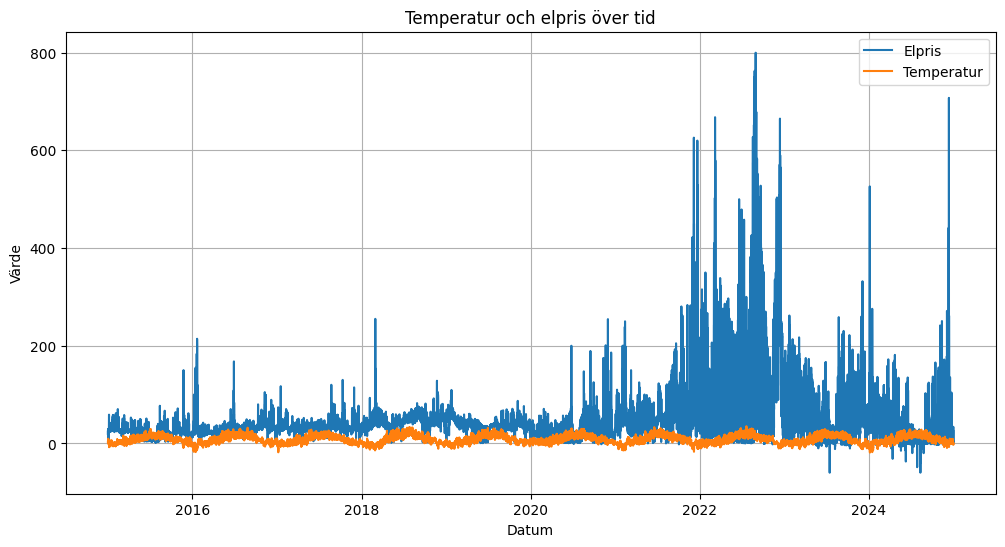

In [353]:
# filter data
#filteredDays = dataDays[(dataDays['city'] == 'Norrköping') & (dataDays['year'] == 2022)]
#filteredWeeks = dataWeeks[(dataWeeks['city'] == 'Norrköping') & (dataWeeks['year'] == 2022)]
#filteredGeneral = dataGeneral[(dataGeneral['city'] == 'Norrköping')]


#pd.set_option('display.max_rows', 10)


start_date = '2015-01-01 00:00:00'
end_date = '2024-12-31 23:59:59'

df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].reset_index(drop=True)
#print(df.isna().sum())
df = df.sort_values("Datetime") 
#display(df)
#print(df['Rain'].mean())
# Show figures
plt.figure(figsize=(12,6))

plt.plot(df['Datetime'], df['Electricity Price'], label='Elpris')
plt.plot(df['Datetime'], df['Temp'], label='Temperatur')
#plt.plot(df['Datetime'], df['Renewable energy'], label='Renewable energy')
#plt.plot(df['Datetime'], df['Cloud coverage'], label='Cloud coverage')
#plt.plot(df['Datetime'], df['Pressure']/10, label='Pressure/10')
#plt.plot(df['Datetime'], df['Rain'], label='Rain')



plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Temperatur och elpris över tid')
plt.legend()
plt.grid(True)
plt.show()

In [292]:
date_time = pd.to_datetime(df.pop('Datetime'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)
print(timestamp_s)
day = 24*60*60
week = day*7
month3 = day*30.437*3
month4 = day*30.437*4 
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['1/3 Month sin'] = np.sin(timestamp_s * (2 * np.pi / month3))
df['1/3 Month cos'] = np.cos(timestamp_s * (2 * np.pi / month3))
df['1/4 Month sin'] = np.sin(timestamp_s * (2 * np.pi / month4))
df['1/4 Month cos'] = np.cos(timestamp_s * (2 * np.pi / month4))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


0        1.609456e+09
1        1.609456e+09
2        1.609459e+09
3        1.609459e+09
4        1.609463e+09
             ...     
36198    1.735672e+09
36199    1.735675e+09
36200    1.735679e+09
36201    1.735682e+09
36202    1.735682e+09
Name: Datetime, Length: 36203, dtype: float64


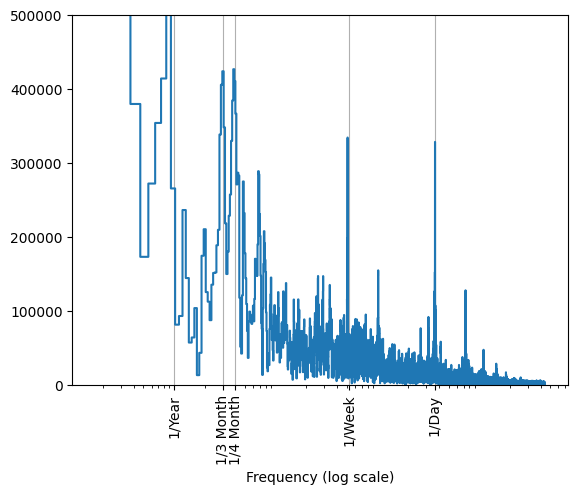

In [293]:
data_EL.describe().transpose()


fft = tf.signal.rfft(data_EL['Electricity Price'])
f_per_dataset = np.arange(len(fft))

n_samples_h = len(data_EL['Electricity Price'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 500000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 3, 4, 52, 365.2524], labels=['1/Year', '1/3 Month','1/4 Month', '1/Week','1/Day'],rotation=90)
plt.grid(axis='x')
_ = plt.xlabel('Frequency (log scale)')

Vi ser att elektricitet priserna har många frekvenser den är beroende av därför borde vi ta med alla dessa i träningsdatan. Det är alltså signifikant när på dagen, när på veckan, när på var 3:e och var 4:e månad vi är och när på året vi är när vi gissar. Alla dessa frekvenser borde vara med i träningsdatan för att få bättre prediktioner.

25342 32582 36203
Temp                        8.649546
Cloud coverage             58.063531
Pressure                 1012.883955
Rain                        0.061582
Wind x                     -0.321650
Wind y                     -0.659179
Solskenstid               882.098572
Långvågs-Irradians        304.613604
Relativ Luftfuktighet      74.094862
Electricity Price          83.600915
Temp Stockholm              8.168558
Temp Sodertalje             7.749968
Temp Borlange               6.663026
Temp Huddinge               7.268175
Temp Vasteras               7.707584
Temp Uppsala                7.948011
Temp Gavle                  6.911061
Day sin                     0.000010
Day cos                     0.000078
Week sin                    0.000051
Week cos                    0.001308
1/3 Month sin               0.009249
1/3 Month cos               0.013367
1/4 Month sin               0.034125
1/4 Month cos               0.011137
Year sin                    0.039703
Year cos            

/tmp/ipykernel_602021/2183674573.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


{'Temp': 0, 'Cloud coverage': 1, 'Pressure': 2, 'Rain': 3, 'Wind x': 4, 'Wind y': 5, 'Solskenstid': 6, 'Långvågs-Irradians': 7, 'Relativ Luftfuktighet': 8, 'Electricity Price': 9, 'Temp Stockholm': 10, 'Temp Sodertalje': 11, 'Temp Borlange': 12, 'Temp Huddinge': 13, 'Temp Vasteras': 14, 'Temp Uppsala': 15, 'Temp Gavle': 16, 'Day sin': 17, 'Day cos': 18, 'Week sin': 19, 'Week cos': 20, '1/3 Month sin': 21, '1/3 Month cos': 22, '1/4 Month sin': 23, '1/4 Month cos': 24, 'Year sin': 25, 'Year cos': 26}
{'Temp': 0}


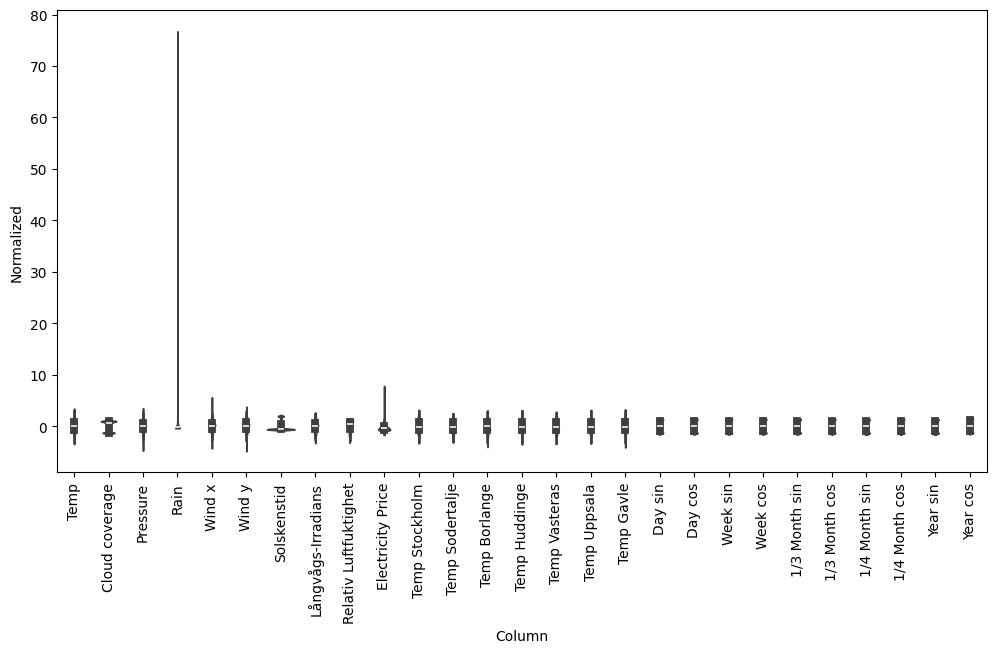

In [294]:
# Split data for training
DataSplitRatios=(0.7,0.2,0.1) # Maybe one should check this sums up to 1?
n = len(df)
split1ix = int(n*DataSplitRatios[0])
split2ix = int(n*(DataSplitRatios[0]+DataSplitRatios[1]))
print(split1ix,split2ix,n)

# normalize data
train_mean = df[0:split1ix].mean()
train_std = df[0:split1ix].std()
dfnorm = (df - train_mean) / train_std
print(train_mean,train_std)

# Visualize
df_std = dfnorm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Label all data
def get_label_columns_indices(dataframe, label_columns=None):
    """
    Returns a dictionary mapping column names to their indices in the given DataFrame.
    Parameters:
        dataframe : pandas.DataFrame
            The DataFrame from which to extract column indices.
        label_columns : list of str, optional
            A list of column names to retrieve indices for. If None, all columns will be included.
    Returns:
        A dictionary where keys are column names and values are their corresponding indices.
    """
    if label_columns is None:
        # Return indices for all columns
        label_columns_indices = {name: i for i, name in enumerate(dataframe.columns)}
    else:
        # Return indices only for the specified label columns
        label_columns_indices = {name: dataframe.columns.get_loc(name) for name in label_columns}
    return label_columns_indices


# Test set labels for columns
lci = get_label_columns_indices(dfnorm,None)
print(lci)
lcol= ['Temp']
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)

In [295]:
# Define a windowing function that converts a dataframe into a TF dataset
# Had to jump to some hoops for this as keras.utils.timeseries_dataset_from_array do not support label_width>1
# https://github.com/keras-team/tf-keras/issues/7
def datasetgen(dataframe, input_width=24, label_width=1, shift=1, batch_size=128,
  label_columns=None, start_index=None, end_index=None, shuffle=False):
  """
  Generate timeseries dataset from the given dataframe containing a data sequence.

  Parameters:
  - dataframe: The source time sequence dataframe.
  - input_width: Number of time steps in each input sequence.
  - label_width: Number of time steps in each label sequence.
  - shift: How many steps to shift the end of the input to get the label.
  - batch_size: Size of batches to generate.
  - label_columns: List of column names to extract as labels. If None, all columns are used.
  - start_index: Start index from the dataframe to consider data. Default is the start of the dataframe.
  - end_index: End index from the dataframe to consider data. Default is the end of the dataframe.
  - shuffle: Whether to shuffle the generated batches. Note: shuffling won't work in the current implementation.

  Returns:
  - A TensorFlow Dataset containing input and label sequences.
  """

  # If end index or start index is not given, assign them to the end or start of the dataframe respectively.
  if end_index is None:
      end_index = len(dataframe) + input_width - 2
  if start_index is None:
      start_index = 0

  # Generate a input timeseries dataset from the dataframe using keras.utils.timeseries_dataset_from_array
  input_ds = keras.utils.timeseries_dataset_from_array(
                  dataframe, targets=None, sequence_length=input_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=start_index, end_index=(end_index-(input_width+shift-1)))

  # Fetch the indices of the label columns from the dataframe.
  label_columns_indices = get_label_columns_indices(dataframe,label_columns) # get the selected columns
  targetsdf = dataframe[list(label_columns_indices)] # Note that we only use names and not the indices
  
  # Generate a timeseries dataset of label sequences from the dataframe.
  # Here we assume that label_width should be less than or equal to shift.
  target_ds = keras.utils.timeseries_dataset_from_array(
                  targetsdf, targets=None, sequence_length=label_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=(start_index+(input_width+shift-label_width)),
                  end_index=end_index-input_width+1)

  # Combine input and target datasets to form a single dataset.
  train_ds = tf.data.Dataset.zip(input_ds,target_ds)

  return train_ds

In [296]:
# Now create the used datasets for part 1

input_width=24    # Input sequence length
shift=1           # How many steps to target
label_width=1     # Target sequence length
lcol=['Temp']     # Target parameter(s)

dfnorm = dfnorm.astype('float64')
#print(dfnorm['Renewable energy'].dtype)  #Is object

train_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split2ix, end_index=None)

# Establish test targets (to show how to unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# Print number of targets (i.e. windows in target dataset)
num_test_targets = test_targets.shape[0]
print(f'No of targets = {num_test_targets}')
# And number of features
num_target_features = targets.shape[-1]
print(f'No of features in target = {num_target_features}')


No of targets = 3596
No of features in target = 1


In [297]:
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("A Batch Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  break

print(f'No batches = {eval_ds.__len__()}')

A Batch Input shape = (128, 24, 27), Output shape = (128, 1, 1)
No batches = 29


In [298]:
# Compile and fit function
MAX_EPOCHS = 1

def compile_and_fit(model, patience=5):
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  start = time.time()
  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])
  end = time.time()
  print(f'Time to run: {end - start:.1f}s')

  return history,model

In [299]:
# Define a first simple LSTM model with 32 units
lstm_model_baseline = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    keras.layers.Dense(units=num_target_features)
])

In [300]:
# Compile and train this model
history_lstm_baseline,lstm_model_baseline1=compile_and_fit(lstm_model_baseline)

198/198 [==============================] - 9s 29ms/step - loss: 0.2711 - mean_absolute_error: 0.3753 - val_loss: 0.1141 - val_mean_absolute_error: 0.2570
Time to run: 9.0s


Test MSE: 0.0928
Test MAE: 0.2265


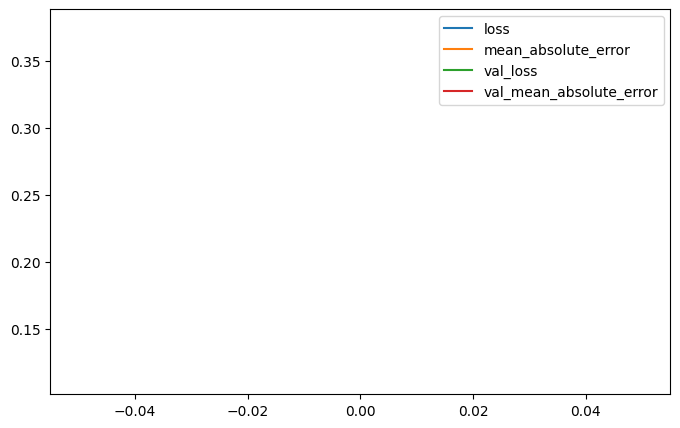

In [301]:
# Evaluate the model.
test_loss, test_metric_mae = lstm_model_baseline1.evaluate(test_ds, verbose=0)
print(f'Test MSE: {test_loss:.4f}')
print(f'Test MAE: {test_metric_mae:.4f}')


# Plot the training curves
pd.DataFrame(history_lstm_baseline.history).plot(figsize=(8,5))
plt.show()

In [302]:
predict = lstm_model_baseline1.predict(test_ds)

29/29 [==============================] - 1s 17ms/step


In [303]:
def unnorm(data,label_columns_index):
  #print(len(label_columns_index),"|",data.shape[-1])
  assert len(label_columns_index) == data.shape[-1]
  tm = train_mean.get(list(label_columns_index)).values
  ts = train_std.get(list(label_columns_index)).values
  return  data * ts + tm

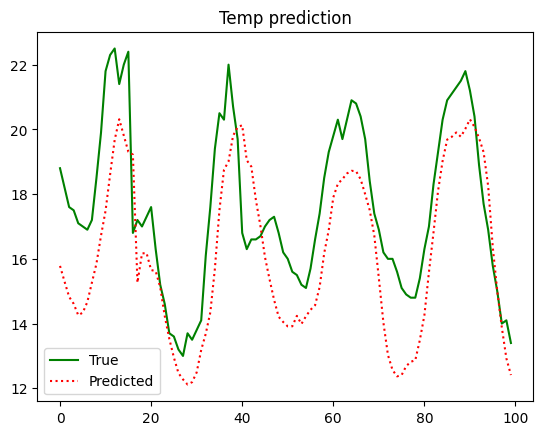

In [304]:
#lcol= ['Renewable energy']
#lci = get_label_columns_indices(dfnorm,lcol)
#print(lci)

ttt = unnorm(test_targets,label_columns_index=lci).numpy().squeeze()
ttp = unnorm(predict,label_columns_index=lci).squeeze()

plt.figure()
plt.plot(ttt[:100],color='g', label='True')
plt.plot(ttp[:100], color='r',linestyle=':', label='Predicted')
plt.title("Temp prediction")
plt.legend()


In [341]:
# A good LSTM model from above but predict all values from 24-48 instead of just 24
# Create the used datasets for part 2.2

input_width=24    # Input sequence length
shift=24          # How many steps to target  (i think it is where it should start so 24
label_width=24    # Target sequence length
lcol=['Electricity Price'] # Target parameter(s)
#dfnorm_train = dfnorm[['Temp', 'Electricity Price', 'Day sin', 'Day cos', 'Week sin', 'Week cos', '1/3 Month sin', '1/3 Month cos', '1/4 Month sin', '1/4 Month cos', 'Year sin', 'Year cos']]
#dfnorm_train = dfnorm[['Temp Stockholm', 'Electricity Price', 'Temp Stockholm', 'Temp Sodertalje', 'Temp Huddinge', 'Temp Vasteras', 'Temp Gavle', 'Temp Borlange', 'Temp Uppsala', 'Week sin', 'Week cos', 'Day sin', 'Day cos', 'Year sin', 'Year cos']]
dfnorm_train = dfnorm[['Temp Uppsala', 'Electricity Price', 'Week sin', 'Week cos', 'Day sin', 'Day cos', 'Year sin', 'Year cos']]
print(dfnorm)
print(dfnorm_train)
train_ds = datasetgen(dfnorm_train, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm_train, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm_train, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split2ix, end_index=None)


# We also need to redefine the compile and fit funciton again

MAX_EPOCHS = 20
def compile_and_fit(model, patience=5):
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  start = time.time()
  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds
                      ,callbacks=[early_stopping]
                      )
  end = time.time()
  print(f'Time to run: {end - start:.1f}s')

  return history,model

# LSTM model
lstm_model_good24 = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)),
    keras.layers.RepeatVector(label_width), # Repeat output for 24 future steps
    keras.layers.LSTM(64, activation='relu', return_sequences=True),
    # Shape => [batch, time, features]
    keras.layers.TimeDistributed(keras.layers.Dense(units=num_target_features))
])

           Temp  Cloud coverage  Pressure      Rain    Wind x    Wind y  \
0     -0.862928        0.945222 -0.546523 -0.143390 -0.614444  0.763933   
1     -0.862928        0.945222 -0.546523 -0.143390 -0.614444  0.763933   
2     -0.827218        0.945222 -0.537826 -0.143390 -0.677959  0.666857   
3     -0.827218        0.945222 -0.537826 -0.143390 -0.677959  0.666857   
4     -0.803412        0.945222 -0.511734 -0.143390 -0.300949  0.575558   
...         ...             ...       ...       ...       ...       ...   
36198 -1.339056        1.238234 -0.798739  3.116446 -0.195297  1.888018   
36199 -1.196217        0.945222 -1.059652  3.116446 -0.738687  2.074171   
36200 -1.089088        0.945222 -1.285777  5.444900 -0.234284  1.333712   
36201 -0.946250        0.945222 -1.503205  3.814982 -1.010084  1.039415   
36202 -0.946250        0.945222 -1.503205  3.814982 -1.010084  1.039415   

       Solskenstid  Långvågs-Irradians  Relativ Luftfuktighet  \
0        -0.627659           -0.50

In [342]:
# Compile and train this model
history_lstm_good24,lstm_model_good241=compile_and_fit(lstm_model_good24)

Epoch 1/20
198/198 [==============================] - 24s 85ms/step - loss: 0.7642 - mean_absolute_error: 0.5603 - val_loss: 0.1887 - val_mean_absolute_error: 0.3254
Epoch 2/20
198/198 [==============================] - 16s 80ms/step - loss: 0.5488 - mean_absolute_error: 0.4735 - val_loss: 0.1254 - val_mean_absolute_error: 0.2535
Epoch 3/20
198/198 [==============================] - 17s 87ms/step - loss: 0.4968 - mean_absolute_error: 0.4508 - val_loss: 0.1249 - val_mean_absolute_error: 0.2515
Epoch 4/20
198/198 [==============================] - 21s 104ms/step - loss: 0.4772 - mean_absolute_error: 0.4444 - val_loss: 0.1030 - val_mean_absolute_error: 0.2280
Epoch 5/20
198/198 [==============================] - 22s 113ms/step - loss: 0.4632 - mean_absolute_error: 0.4335 - val_loss: 0.0957 - val_mean_absolute_error: 0.2209
Epoch 6/20
198/198 [==============================] - 20s 103ms/step - loss: 0.4541 - mean_absolute_error: 0.4344 - val_loss: 0.1035 - val_mean_absolute_error: 0.2247
E

Test MSE: 0.1367
Test MAE: 0.1994
{'Electricity Price': 1}
4/4 [==============================] - 1s 10ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


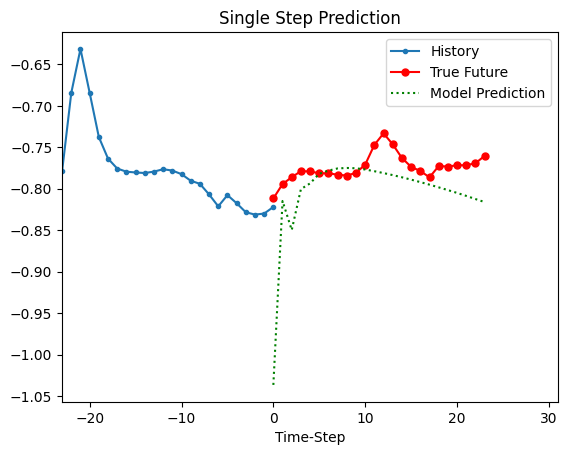

4/4 [==============================] - 0s 11ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


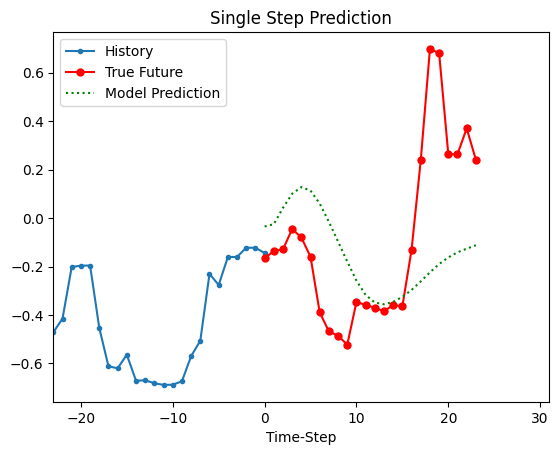

4/4 [==============================] - 0s 13ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


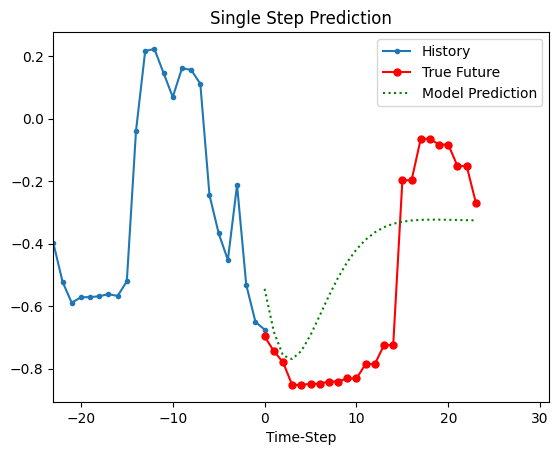

4/4 [==============================] - 0s 20ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


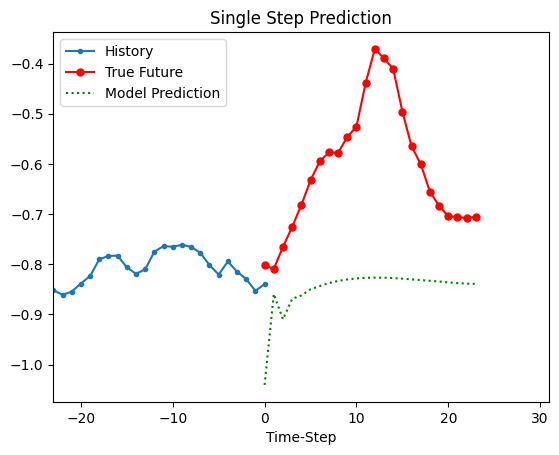

4/4 [==============================] - 0s 20ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


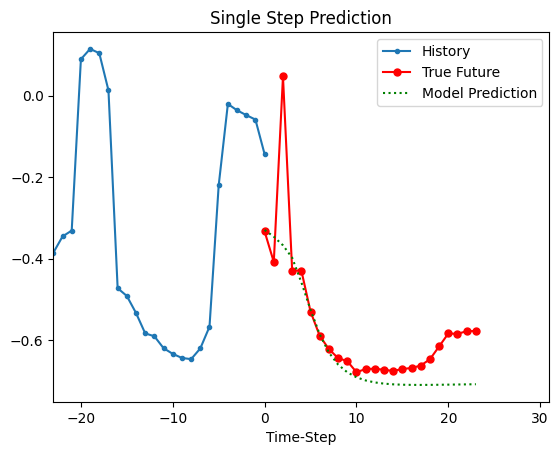

4/4 [==============================] - 0s 10ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


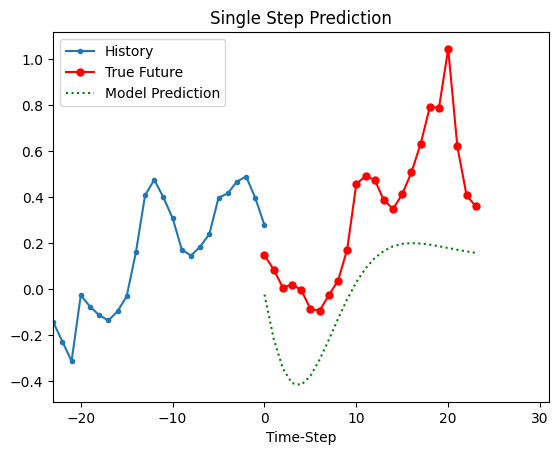

4/4 [==============================] - 0s 12ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


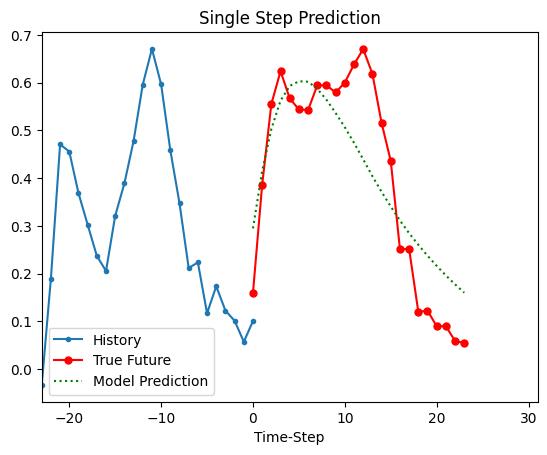

4/4 [==============================] - 0s 11ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


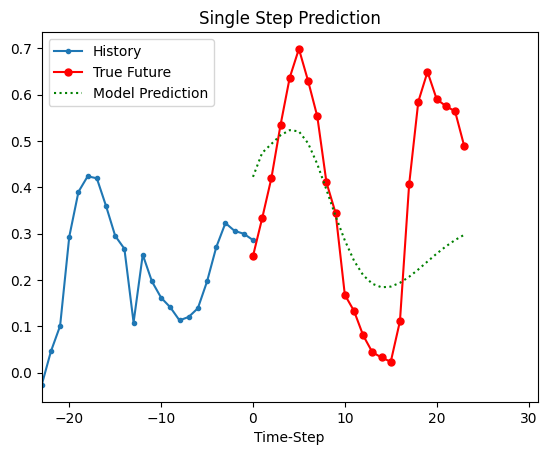

4/4 [==============================] - 0s 12ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


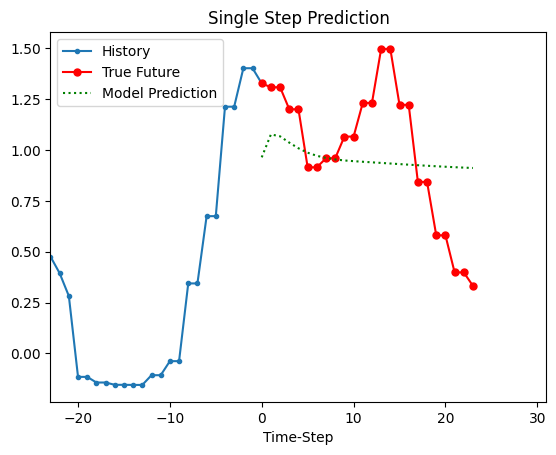

4/4 [==============================] - 0s 10ms/step
(128, 24, 8)
(128, 24, 1)
(128, 24, 1)


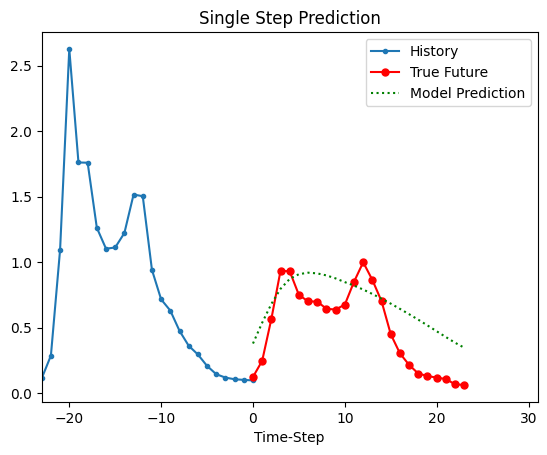

In [343]:
# Evaluate the model.
test_loss, test_metric_mae = lstm_model_good241.evaluate(test_ds, verbose=0)
print(f'Test MSE: {test_loss:.4f}')
print(f'Test MAE: {test_metric_mae:.4f}')


lci = get_label_columns_indices(dfnorm_train,lcol)
print(lci)


# Plot the training curves
#pd.DataFrame(history_lstm_good24.history).plot(figsize=(8,5))
#plt.show()

def show_plot3(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "r.-", "g:"]
    time_steps = list(range(-(plot_data[0].shape[0])+1 ,1))
    time_steps_future = list(range(0,(plot_data[2].shape[0])))
    #print(time_steps_future)
    if delta:
        future = delta
    else:
        future = 0

    plt.figure()
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(time_steps_future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future +30)])
    plt.xlabel("Time-Step")
    plt.show()
    return

pred_pos = 1
for x, y in val_ds.take(10):
    preds = lstm_model_good241.predict(x)
    print(x.shape)
    print(y.shape)
    print(preds.shape)
    show_plot3(
        [x[0][:, pred_pos].numpy(), y[0].numpy(), preds[0]],
        pred_pos,
        "Single Step Prediction",
    )
